IMPORT PACKAGES

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import color
from scipy import stats
import imageio
import mpmath
from PIL import Image
import os
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from skimage.transform.integral import integral_image, integrate
from scipy.ndimage import convolve, gaussian_laplace, prewitt
from skimage import io, color, img_as_float
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage.feature import local_binary_pattern
from scipy.ndimage import convolve, gaussian_laplace, prewitt
from skimage.color import rgb2gray, rgb2hsv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


DEFINE IMAGES

In [ ]:
# Load the images
train_image = cv2.imread('/content/drive/MyDrive/image-35.jpg')
val_image = cv2.imread('/content/drive/MyDrive/image-83.jpg')
test_image = cv2.imread('/content/drive/MyDrive/image-110.jpg')

train_mask = cv2.imread('/content/drive/MyDrive/mask-35.png')
val_mask = cv2.imread('/content/drive/MyDrive/mask-83.png')
test_mask = cv2.imread('/content/drive/MyDrive/mask-110.png')

CONVERT IMAGES TO RGB , HSV AND GRAYSCALE

In [ ]:
train_image = np.moveaxis(train_image, -1, 0)[::-1]
train_image = np.moveaxis(train_image, 0, -1)
val_image = np.moveaxis(val_image, -1, 0)[::-1]
val_image = np.moveaxis(val_image, 0, -1)
test_image = np.moveaxis(test_image, -1, 0)[::-1]
test_image = np.moveaxis(test_image, 0, -1)

train_image_gray = rgb2gray(train_image)
val_image_gray = rgb2gray(val_image)
test_image_gray = rgb2gray(test_image)
train_image_hsv = rgb2hsv(train_image)
val_image_hsv = rgb2hsv(val_image)
test_image_hsv = rgb2hsv(test_image)

In [ ]:
# Normalize the images by scaling them to [0, 1]
train_image_float = train_image.astype(np.float32) / 255.0
train_mask_float = train_mask.astype(np.float32) / 255.0
train_mask_binary = np.round(train_mask_float).astype(np.uint8)

val_image_float = val_image.astype(np.float32) / 255.0
val_mask_float = val_mask.astype(np.float32) / 255.0
val_mask_binary = np.round(val_mask_float).astype(np.uint8)

test_image_float = test_image.astype(np.float32) / 255.0
test_mask_float = test_mask.astype(np.float32) / 255.0
test_mask_binary = np.round(test_mask_float).astype(np.uint8)

REDISPLAY IMAGES

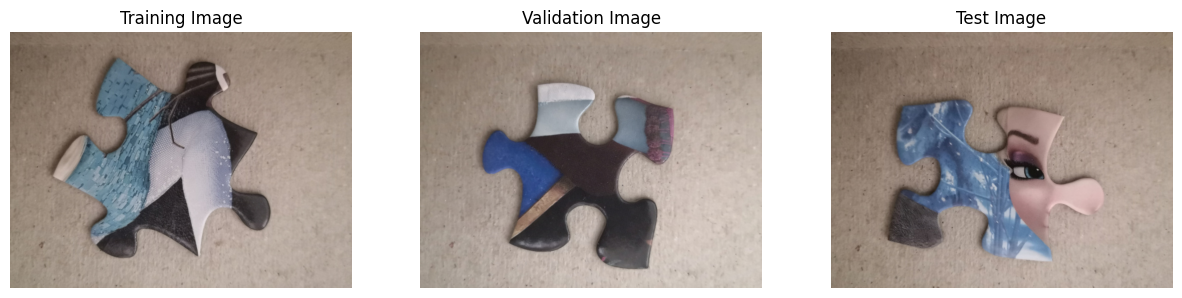

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(train_image_float)
plt.title('Training Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(val_image_float)
plt.title('Validation Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(test_image_float)
plt.title('Test Image')
plt.axis('off')

plt.show()

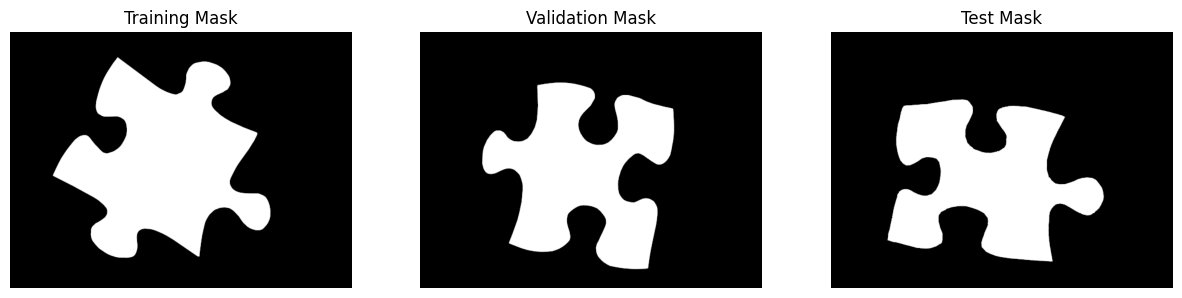

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(train_mask_float)
plt.title('Training Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(val_mask_float)
plt.title('Validation Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(test_mask_float)
plt.title('Test Mask')
plt.axis('off')

plt.show()

QUESTION 1 : GAUSSIAN , LOG AND DOG FILTERS

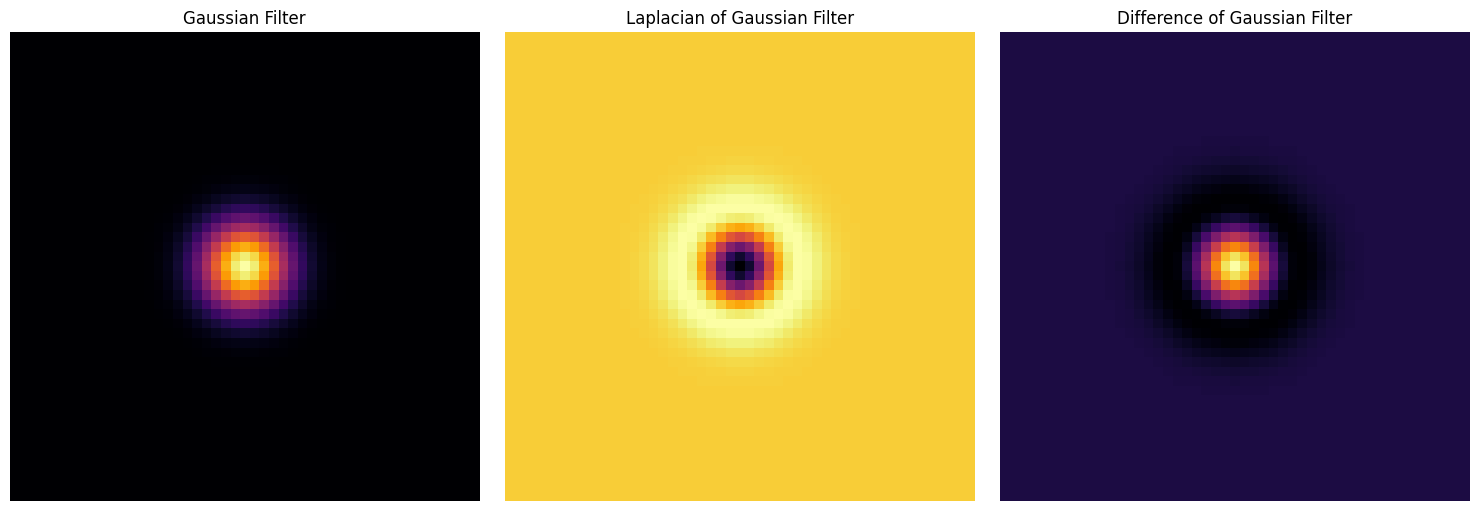

In [ ]:
def gaussian_filter(size, sigma):
    center = size // 2
    x = np.arange(-center, center + 1)
    y = np.arange(-center, center + 1)
    x, y = np.meshgrid(x, y)

    gaussian = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

    return gaussian

def laplacian_of_gaussian_filter(size, sigma):
    center = size // 2
    x = np.arange(-center, center + 1)
    y = np.arange(-center, center + 1)
    x, y = np.meshgrid(x, y)

    term1 = (1 - (x**2 + y**2) / (2 * sigma**2))
    term2 = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    log = - (1 / (np.pi * sigma**4)) * term1 * term2

    return log

def difference_of_gaussian_filter(size, sigma, K):
    center = size // 2
    x = np.arange(-center, center + 1)
    y = np.arange(-center, center + 1)
    x, y = np.meshgrid(x, y)

    gauss1 = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    gauss2 = (1 / (2 * np.pi * (K**2) * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * (K**2) * sigma**2))

    # Difference of Gaussians
    dog = gauss1 - gauss2

    return dog

def apply_filter_rgb(image, filter_kernel):
    r, g, b = cv2.split(image)

    # Apply the filter to each channel
    r_filtered = convolve(r, filter_kernel)
    g_filtered = convolve(g, filter_kernel)
    b_filtered = convolve(b, filter_kernel)

    # Merge the channels back together
    filtered_image = cv2.merge([r_filtered, g_filtered, b_filtered])

    return filtered_image

def normalize(image):
    image_min = np.min(image)
    image_max = np.max(image)
    return (image - image_min) / (image_max - image_min)

# Parameters
gaussian_size = 49
gaussian_sigma = np.sqrt(10)

log_size = 49
log_sigma = np.sqrt(10)

dog_size = 49
dog_sigma = np.sqrt(10)
K = 1.2

# Creating filters with individual parameters
gaussian_kernel = gaussian_filter(gaussian_size, gaussian_sigma)
log_filter = laplacian_of_gaussian_filter(log_size, log_sigma)
dog_filter = difference_of_gaussian_filter(dog_size, dog_sigma, K)

# Applying the filters to the RGB image
gaussian_filtered_image = normalize(apply_filter_rgb(train_image_float, gaussian_kernel))
log_filtered_image = normalize(apply_filter_rgb(train_image_float, log_filter))
dog_filtered_image = normalize(apply_filter_rgb(train_image_float, dog_filter))

# Plot the filters
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(gaussian_kernel, cmap='inferno')
plt.title('Gaussian Filter')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(log_filter, cmap='inferno')
plt.title('Laplacian of Gaussian Filter')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dog_filter, cmap='inferno')
plt.title('Difference of Gaussian Filter')
plt.axis('off')

plt.tight_layout()
plt.show()

APPLY FILTERS TO IMAGE

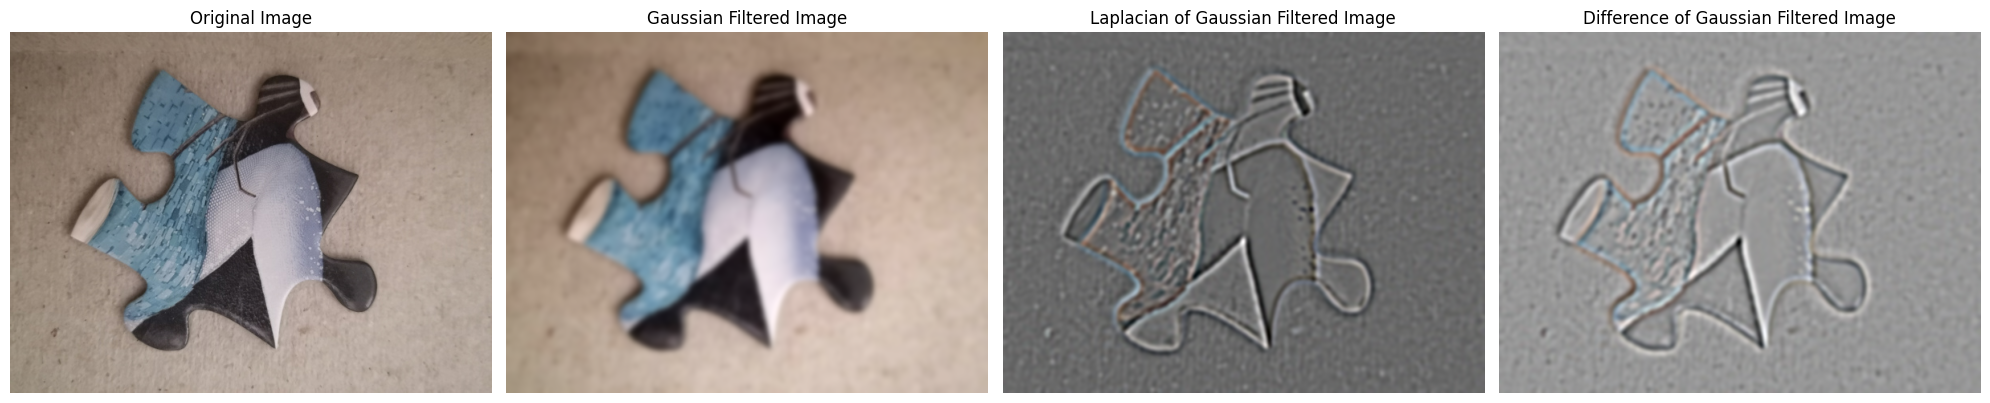

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.imshow(train_image, cmap='inferno')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(gaussian_filtered_image, cmap='inferno')
plt.title('Gaussian Filtered Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(log_filtered_image, cmap='inferno')
plt.title('Laplacian of Gaussian Filtered Image')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(dog_filtered_image , cmap='inferno')
plt.title('Difference of Gaussian Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()

RFS BANK

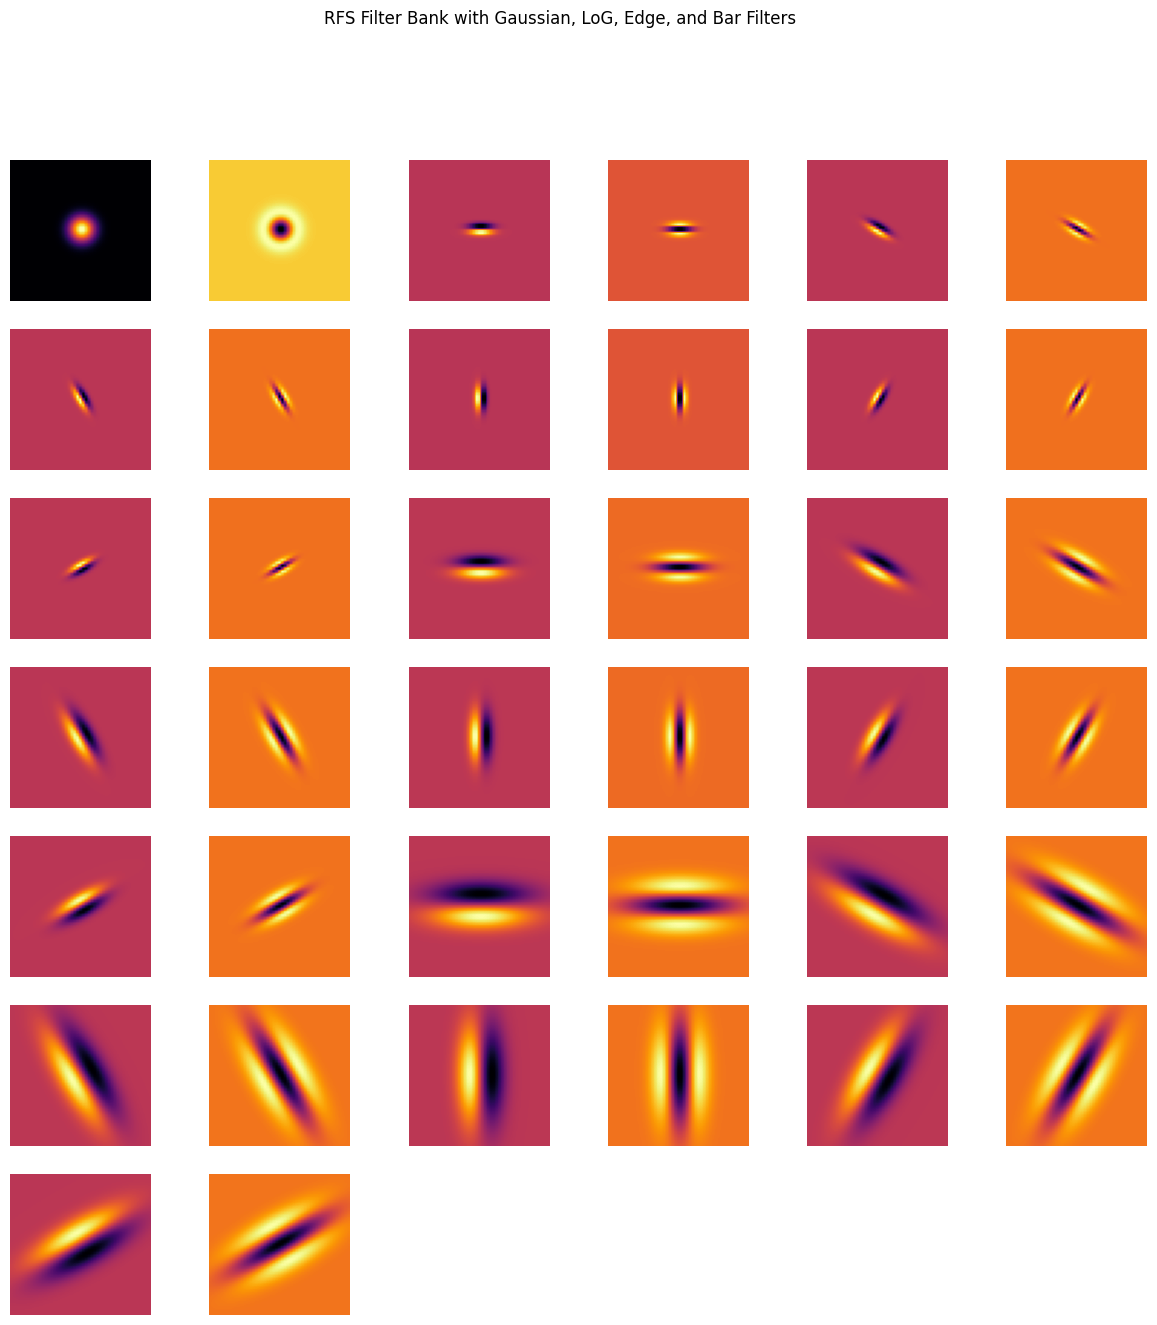

In [ ]:
def gaussian_1d(x, sigma):
    """1D Gaussian function."""
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(x**2) / (2 * sigma**2))

def rotated_coordinates(x, y, theta):
    """Compute the rotated coordinates x' and y' based on theta."""
    x_prime = x * np.cos(theta) - y * np.sin(theta)
    y_prime = x * np.sin(theta) + y * np.cos(theta)
    return x_prime, y_prime

def gaussian_2d(x, y, theta, sigma_x, sigma_y):
    """Compute the 2D Gaussian function g(x, y, θ, σx, σy)."""
    x_prime, y_prime = rotated_coordinates(x, y, theta)
    return gaussian_1d(x_prime, sigma_x) * gaussian_1d(y_prime, sigma_y)

def gaussian_edge_filter(size, theta, sigma_x, sigma_y):
    """Create a Gaussian edge filter (first derivative with respect to y')."""
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)

    # Flip y-axis before calculation
    y = np.flipud(y)

    x_prime, y_prime = rotated_coordinates(x, y, theta)

    # Calculate the edge filter as described
    f_x_prime = gaussian_1d(x_prime, sigma_x)
    f_y_prime = gaussian_1d(y_prime, sigma_y) * (-y_prime / sigma_y**2)

    edge_filter = f_x_prime * f_y_prime
    return edge_filter

def gaussian_bar_filter(size, theta, sigma_x, sigma_y):
    """Create a Gaussian bar filter (second derivative with respect to y')."""
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)

    # Flip y-axis before calculation
    y = np.flipud(y)

    x_prime, y_prime = rotated_coordinates(x, y, theta)

    # Calculate the bar filter as described
    f_x_prime = gaussian_1d(x_prime, sigma_x)
    f_y_prime = gaussian_1d(y_prime, sigma_y) * (y_prime**2 - sigma_y**2) / sigma_y**4

    bar_filter = f_x_prime * f_y_prime
    return bar_filter

def laplacian_of_gaussian(size, sigma):
    """Manually implements the Laplacian of Gaussian (LoG) filter."""
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)

    # Flip y-axis before calculation
    y = np.flipud(y)

    g = gaussian_2d(x, y, 0, sigma, sigma)  # No rotation, sigma_x = sigma_y
    d2g_dx2 = (x**2 - sigma**2) * g / sigma**4
    d2g_dy2 = (y**2 - sigma**2) * g / sigma**4

    log_filter = d2g_dx2 + d2g_dy2
    return log_filter

def create_gaussian_filter(size, sigma):
    """Creates a 2D Gaussian filter with specified size and sigma."""
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)

    # Flip y-axis before calculation
    y = np.flipud(y)

    return np.exp(-(x**2 + y**2) / (2 * sigma**2))

def generate_rfs_bank():
    """Generate the RFS bank with the specified parameters."""
    size = 49
    sigma_gaussian = np.sqrt(10)

    rfs_filters = [gaussian_filter, log_filter]

    sigma_pairs = [(3, 1), (6, 2), (12, 4)]
    thetas = [0, np.pi / 6, 2 * np.pi / 6, 3 * np.pi / 6, 4 * np.pi / 6, 5 * np.pi / 6]

    for sigma_x, sigma_y in sigma_pairs:
        for theta in thetas:
            edge_filter = gaussian_edge_filter(size, theta, sigma_x, sigma_y)
            bar_filter = gaussian_bar_filter(size, theta, sigma_x, sigma_y)
            rfs_filters.extend([edge_filter, bar_filter])


    return rfs_filters,sigma_pairs,thetas

size = 49
sigma_gaussian = np.sqrt(10)
# Create the rotationally symmetric Gaussian and manually implemented LoG filters
gaussian_filter = create_gaussian_filter(size, sigma_gaussian)
log_filter = laplacian_of_gaussian(size, sigma_gaussian)

# Generate the RFS filter bank
rfs_bank,sigma_pairs,thetas = generate_rfs_bank()

# Plot all 38 filters
fig, axes = plt.subplots(7, 6, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    if i < len(rfs_bank):
        ax.imshow(rfs_bank[i], cmap='inferno')
        ax.axis('off')
    else:
        ax.remove()

plt.suptitle('RFS Filter Bank with Gaussian, LoG, Edge, and Bar Filters')
plt.show()

RFS APPLIED TO AN IMAGE: RFS Captures edges and corners and lines

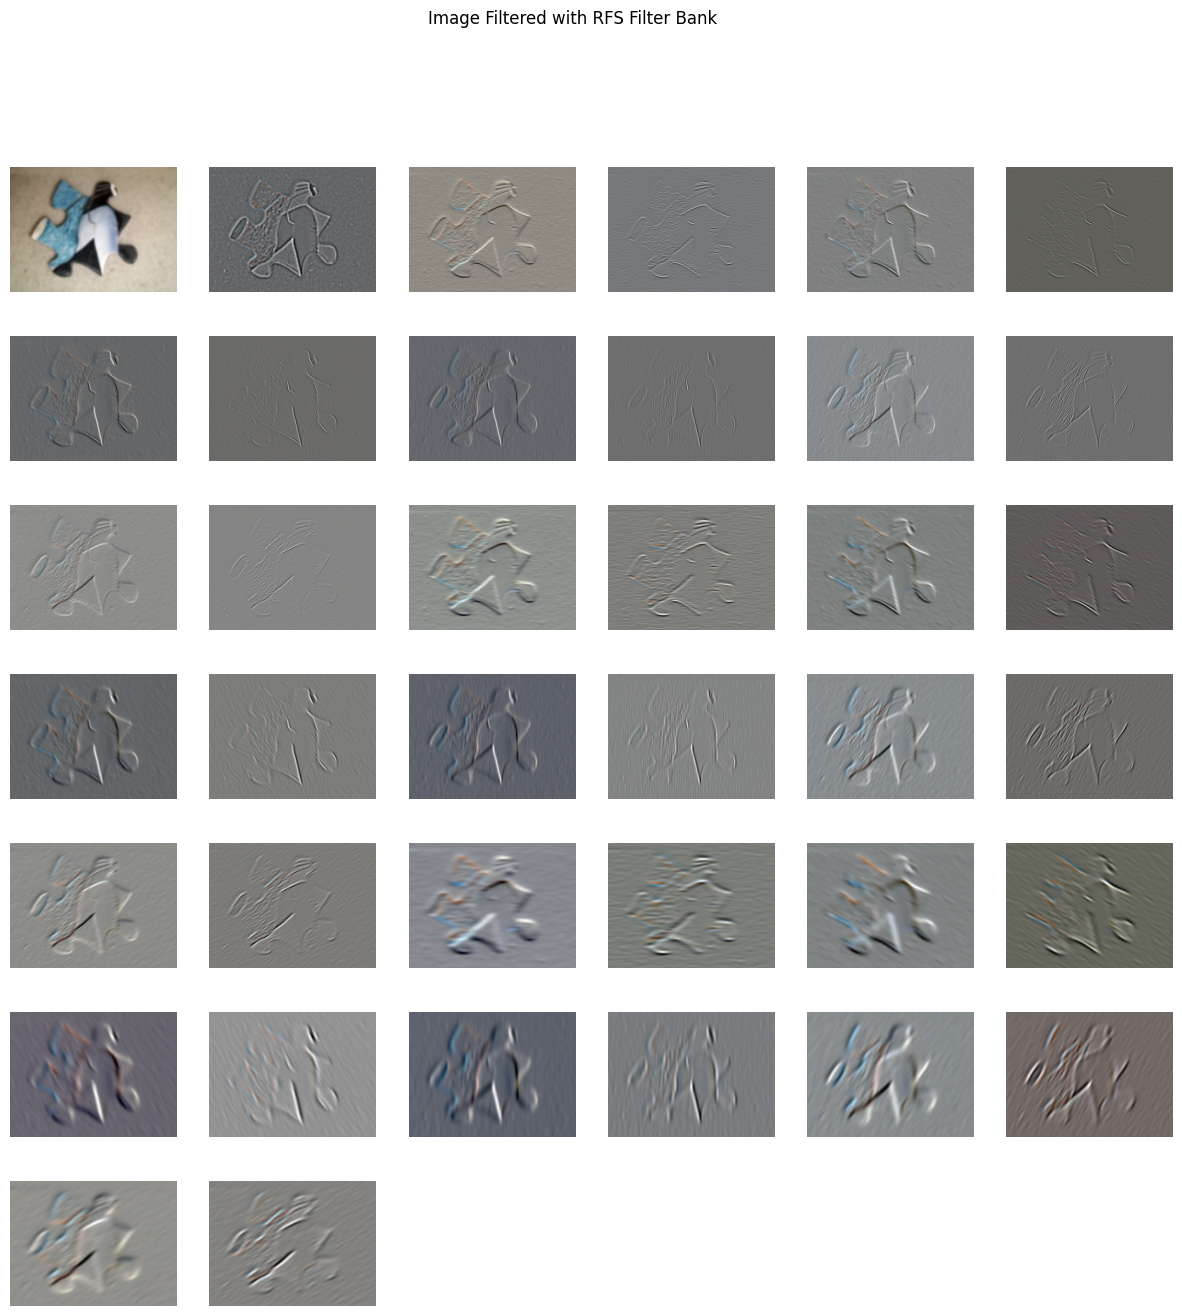

In [ ]:
def apply_filters_to_image(image, filters):
    """Applies a list of filters to an image."""
    filtered_images = []

    for filter in filters:
        filtered_image = np.zeros_like(image)
        for channel in range(image.shape[2]):
            filtered_image[:, :, channel] = normalize(convolve(image[:, :, channel], filter, mode='reflect'))

        filtered_images.append(filtered_image)

    return filtered_images

# Load image
image = train_image_float

# Generate the RFS filter bank
rfs_bank,sigma_pairs,thetas = generate_rfs_bank()

# Apply the filter bank to the image
filtered_images = apply_filters_to_image(image, rfs_bank)

# Plot the results
num_filters = len(rfs_bank)
fig, axes = plt.subplots(7, 6, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < num_filters:
        # Clip the filtered image to [0, 1] range for display
        filtered_img_clipped = (filtered_images[i])
        ax.imshow(filtered_img_clipped , cmap= 'inferno')
        ax.axis('off')
    else:
        ax.remove()

plt.suptitle('Image Filtered with RFS Filter Bank')
plt.show()

MR8 BANK : Filter captures both texture and edges. Response 1 and 3 are mode detailed. Very good at segmenting similar parts of the image

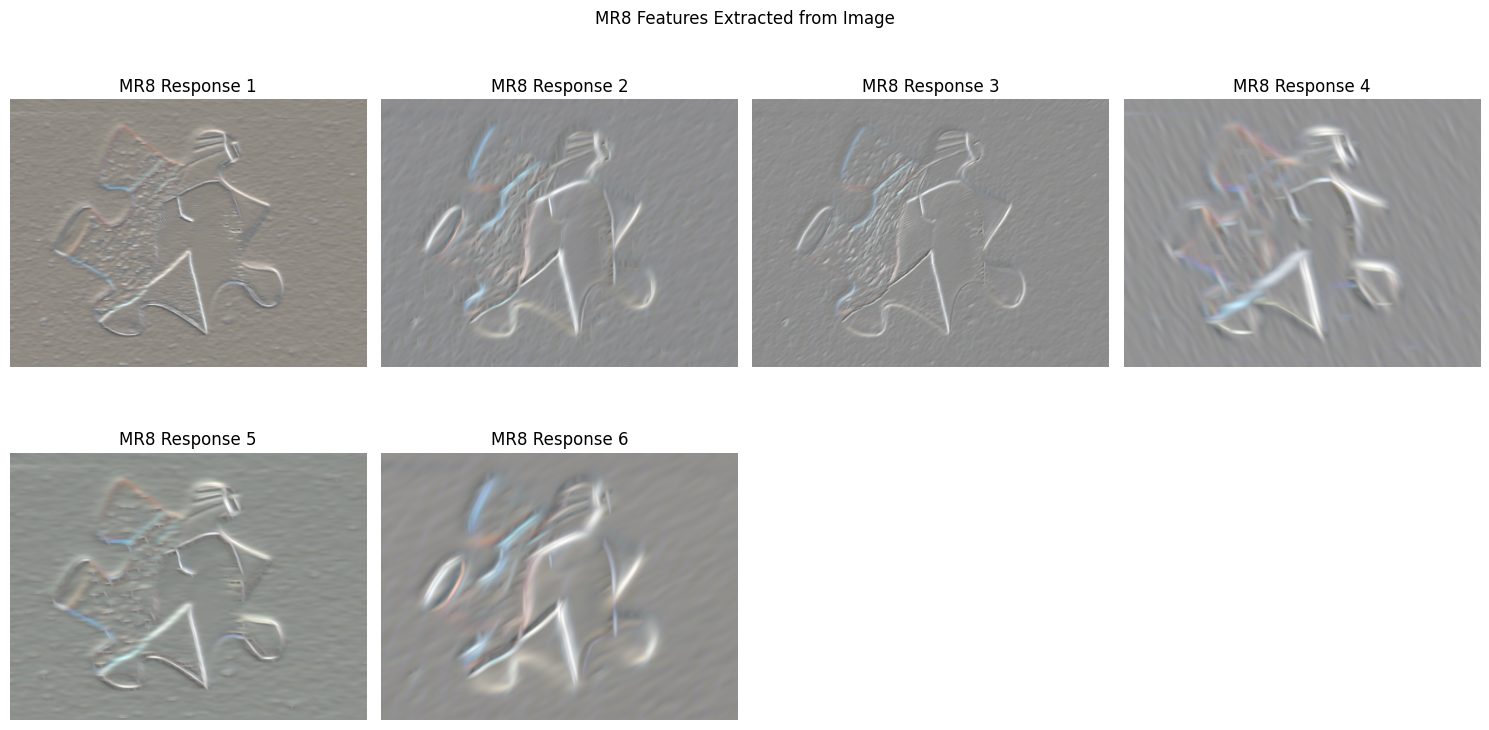

In [ ]:
def apply_filter_to_rgb(image, filter_kernel):
    """Applies a 2D filter to each channel of an RGB image."""
    filtered_channels = [normalize(convolve(image[:, :, channel], filter_kernel, mode='reflect')) for channel in range(3)]
    return np.stack(filtered_channels, axis=2)

def apply_rfs_bank_to_image(image, rfs_bank, sigma_pairs, thetas):
    """Applies each filter in the RFS bank to the RGB image and extracts MR8 features."""
    mr8_features = []

    # Apply the edge and bar filters, and compute the maximal response for each sigma pair
    for i in range(len(sigma_pairs)):
        edge_responses, bar_responses = [], []

        for theta in thetas:
            edge_filter = rfs_bank[2 + i * len(thetas) + thetas.index(theta)]
            bar_filter = rfs_bank[2 + len(sigma_pairs) * len(thetas) + i * len(thetas) + thetas.index(theta)]
            edge_responses.append(apply_filter_to_rgb(image, edge_filter))
            bar_responses.append(apply_filter_to_rgb(image, bar_filter))

        mr8_features.append(np.max(edge_responses, axis=0))
        mr8_features.append(np.max(bar_responses, axis=0))

    return mr8_features

# Load an image
image = train_image_float

rfs_bank, sigma_pairs, thetas = generate_rfs_bank()

# Apply the RFS bank to the image and extract MR8 features
mr8_features = apply_rfs_bank_to_image(image, rfs_bank, sigma_pairs, thetas)

# Plot the MR8 features
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i, ax in enumerate(axes.flat):
    if i < len(mr8_features):
        ax.imshow(mr8_features[i] , cmap = 'inferno')
        ax.set_title(f"MR8 Response {i + 1}")
        ax.axis('off')
    else:
        ax.remove()

plt.suptitle('MR8 Features Extracted from Image')
plt.tight_layout()
plt.show()

LOCAL BINARY PATTERN : LBP filter results are noisy. Filter very sensitive to any change in texture

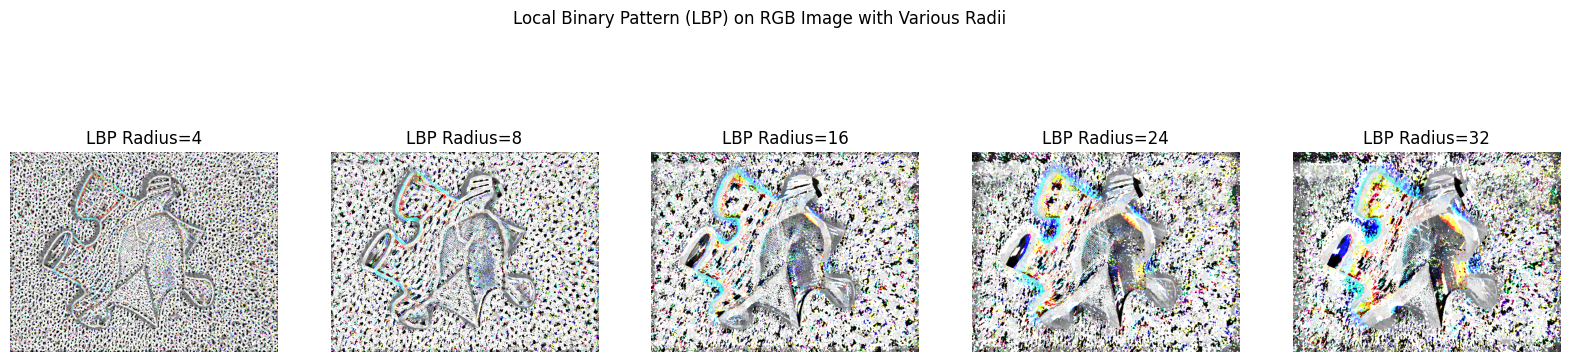

In [ ]:
def apply_lbp_to_rgb_image(image, radii, num_points):
    lbp_images = []

    # Apply LBP to each radius
    for radius in radii:
        lbp_channels = []

        # Apply LBP to each channel
        for channel in range(3):
            lbp_channel = local_binary_pattern(image[:, :, channel], P=num_points, R=radius, method='uniform')
            lbp_channels.append(normalize(lbp_channel))

        # Stack the LBP channels to form the RGB image
        lbp_image_rgb = np.stack(lbp_channels, axis=2)
        lbp_images.append(lbp_image_rgb)

    return lbp_images

def plot_lbp_images_rgb(lbp_images, radii):
    """Plots LBP results for an RGB image with various radii."""
    fig, axes = plt.subplots(1, len(radii), figsize=(20, 5))

    for i, (lbp_image, radius) in enumerate(zip(lbp_images, radii)):
        axes[i].imshow(lbp_image)  # Convert to uint8 for plotting
        axes[i].set_title(f'LBP Radius={radius}')
        axes[i].axis('off')

    plt.suptitle('Local Binary Pattern (LBP) on RGB Image with Various Radii')
    plt.show()

image = (train_image_float * 255).astype(np.uint8)

radii = [4, 8, 16, 24, 32]
num_points = 12

lbp_images_rgb = apply_lbp_to_rgb_image(image, radii, num_points)

# Plot LBP results for each radius
plot_lbp_images_rgb(lbp_images_rgb, radii)

INTERGRAL IMAGES

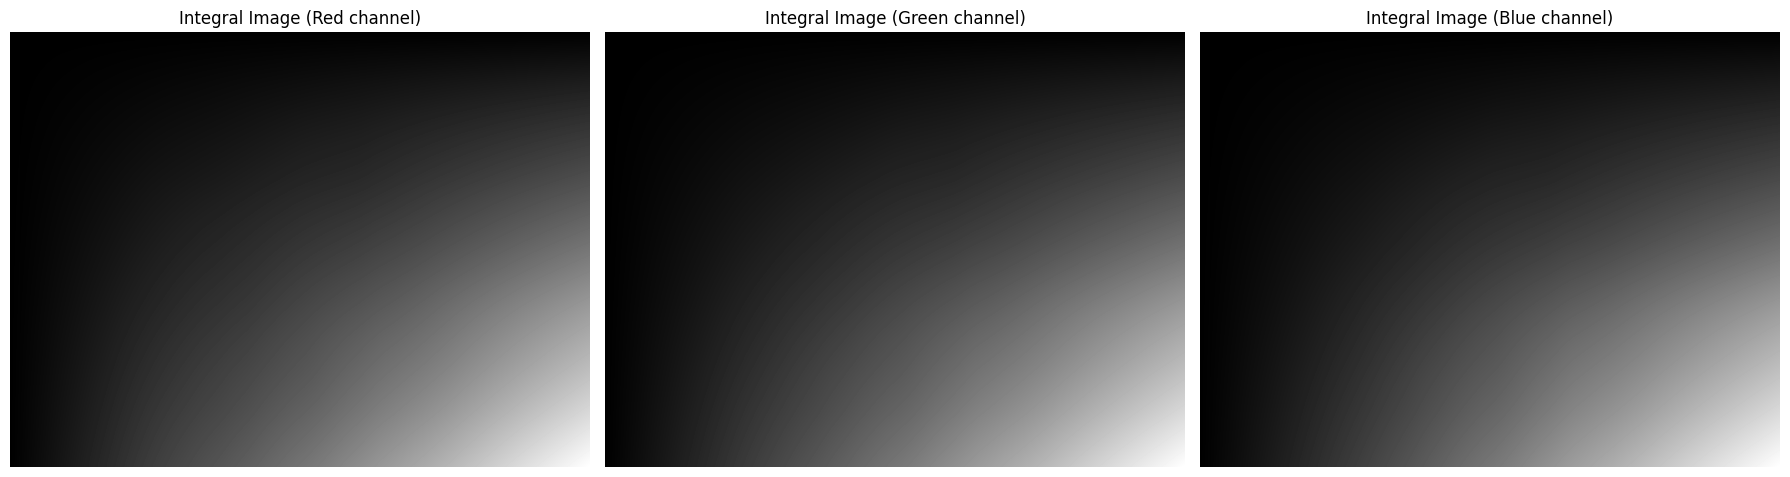

In [ ]:
# Compute Integral images for each RGB channel
integral_images = [integral_image(train_image_float[:, :, i]) for i in range(3)]

# Plot the integral images for verification
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
channels = ['Red', 'Green', 'Blue']
for i in range(3):
    ax[i].imshow(integral_images[i], cmap="gray")
    ax[i].set_title(f"Integral Image ({channels[i]} channel)")
    ax[i].axis("off")

plt.tight_layout()
plt.show()

HAAR FILTERS : Filter detects features well especially at higher filter size, there is a higher response with the puzzle piece

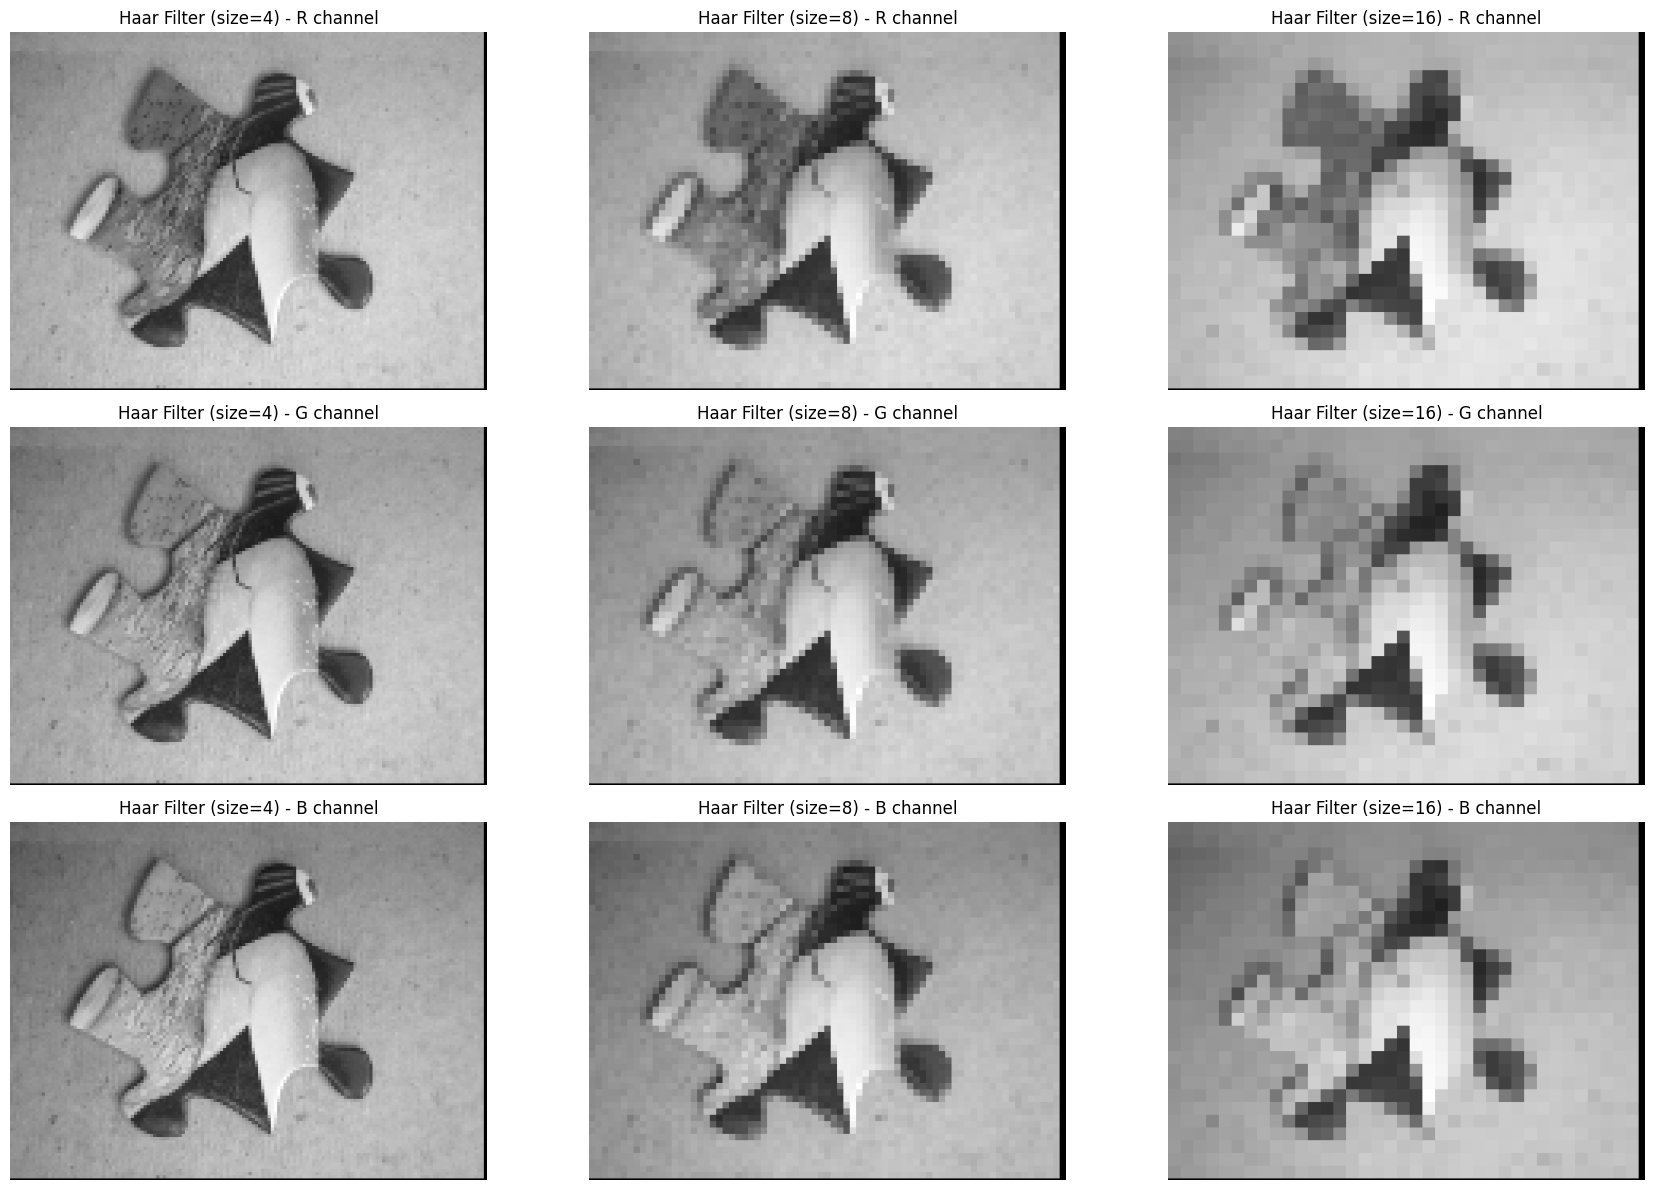

In [ ]:
def checkered_haar_filter(size):

    # Initialize the filter with ones
    filter_kernel = np.ones((size, size))

    # Define the regions for the Haar pattern
    half_size = size // 2
    filter_kernel[:half_size, half_size:] = -1  # Top-right quadrant
    filter_kernel[half_size:, :half_size] = -1  # Bottom-left quadrant

    return filter_kernel

def apply_haar_filter(integral_image, haar_filter):

    filter_size = haar_filter.shape[0]
    filtered_image = np.zeros_like(integral_image)

    # Apply the Haar filter to each region of the integral image
    for i in range(0, integral_image.shape[0] - filter_size, filter_size):
        for j in range(0, integral_image.shape[1] - filter_size, filter_size):
            filtered_image[i:i+filter_size, j:j+filter_size] = np.sum(
                integral_image[i:i+filter_size, j:j+filter_size] * haar_filter
            )

    return filtered_image

# Define filter sizes and apply Haar filters to each channel
filter_sizes = [4, 8, 16]
channels = ["R", "G", "B"]  # Assuming RGB channels

import numpy as np

def apply_and_normalize_haar_filters(image, filter_sizes):
    haar_filtered_images = []
    # Compute integral images for each RGB channel
    integral_images = [integral_image(image[:, :, i]) for i in range(3)]

    for filter_size in filter_sizes:
        # Generate the Haar filter for the given size
        haar_filter = checkered_haar_filter(filter_size)

        channel_results = []
        for i in range(3):  # For each RGB channel
            haar_image = apply_haar_filter(integral_images[i], haar_filter)
            # Normalize the result
            haar_image = (haar_image - np.min(haar_image)) / (np.max(haar_image) - np.min(haar_image))
            channel_results.append(haar_image)

        haar_filtered_images.append(channel_results)

    return np.array(haar_filtered_images)

filter_sizes = [4, 8, 16]
haar_filtered_images = apply_and_normalize_haar_filters(train_image_float, filter_sizes)

# Plot the Haar filter results
fig, ax = plt.subplots(3, len(filter_sizes), figsize=(18, 12))
for i, filter_size in enumerate(filter_sizes):
    for j in range(3):
        ax[j, i].imshow(haar_filtered_images[i][j], cmap="gray")
        ax[j, i].set_title(f"Haar Filter (size={filter_size}) - {channels[j]} channel")
        ax[j, i].axis("off")

plt.tight_layout()
plt.show()

TEXTONS AND CLASSIFICATION

4.1 PREWITT AND LAPLACIAN FILTERS

In [ ]:
prewitt_vertical_kernel = np.array([[-1,  0,  1],
                                    [-1,  0,  1],
                                    [-1,  0,  1]])

prewitt_horizontal_kernel = np.array([[-1, -1, -1],
                                      [ 0,  0,  0],
                                      [ 1,  1,  1]])

laplacian_kernel = np.array([[ 0,  1,  0],
                             [ 1, -4,  1],
                             [ 0,  1,  0]])

def apply_filters_cv2(image, prewitt_vertical_kernel, prewitt_horizontal_kernel, laplacian_kernel):
    channels = image.shape[2]

    # Initialize output images
    prewitt_v = np.copy(image)
    prewitt_h = np.copy(image)
    laplacian = np.copy(image)

    for i in range(channels):
        # Apply convolution
        prewitt_v[:, :, i] = cv2.filter2D(image[:, :, i], -1, prewitt_vertical_kernel)
        prewitt_h[:, :, i] = cv2.filter2D(image[:, :, i], -1, prewitt_horizontal_kernel)
        laplacian[:, :, i] = cv2.filter2D(image[:, :, i], -1, laplacian_kernel)

    return prewitt_v, prewitt_h, laplacian

EXTRACT FEATURE VECTOR  

EXTRACTING ALL THE MENTIONED FEATURES

In [ ]:
def extract_features_all(image):

    # Convert to grayscale for some filters
    gray_image = color.rgb2gray(image)

    gaussian_filtered_image = normalize(apply_filter_rgb(image, gaussian_kernel))
    log_filtered_image= normalize(apply_filter_rgb(image, log_filter))
    dog_filtered_image = normalize(apply_filter_rgb(image, dog_filter))

    # Apply MR8 filters
    rfs_bank, sigma_pairs, thetas = generate_rfs_bank()
    mr8_features = apply_rfs_bank_to_image(image, rfs_bank, sigma_pairs, thetas)
    mr8_features = np.moveaxis(mr8_features, 0, -1)
    mr8_features = mr8_features.reshape(450, 600, -1)

    # Apply RFS filters  --- done
    rfs_features = apply_filters_to_image(image, rfs_bank)
    rfs_features = np.moveaxis(rfs_features, 0, -1)
    rfs_features = rfs_features.reshape(450, 600, -1)

    # Apply Haar filters
    haar_features = apply_and_normalize_haar_filters(image, filter_sizes)
    reshaped_array = haar_features.reshape(9, 450, 600)
    haar_features = np.transpose(reshaped_array, (1, 2, 0))

    # Apply Local Binary Pattern (LBP)------ done
    #gray_image_int = (gray_image * 255).astype(np.uint8)
    lbp_features = apply_lbp_to_rgb_image(image, radii, num_points)
    lbp_features = np.moveaxis(lbp_features,0,-1)
    lbp_features =  lbp_features.reshape(450, 600, -1)

    # RGB channels
    rgb_features = image

    # HSV channels
    hsv_features= color.rgb2hsv(image)

    # Prewitt  and Laplacian filter
    image_prewitt_v, image_prewitt_h, image_laplacian = apply_filters_cv2(
    image, prewitt_vertical_kernel, prewitt_horizontal_kernel, laplacian_kernel)


    def stack_features(*feature_arrays):

        # Check that all arrays have the same height and width
        base_shape = feature_arrays[0].shape[:2]
        for array in feature_arrays:
            if array.shape[:2] != base_shape:
                raise ValueError("All feature arrays must have the same height and width.")

        # Stack all feature arrays along the last axis
        stacked_features = np.concatenate(feature_arrays, axis=2)

        return stacked_features

    # Example usage
    features = stack_features(gaussian_filtered_image, log_filtered_image, dog_filtered_image,
                          mr8_features, rfs_features, haar_features, lbp_features,
                          rgb_features, hsv_features, image_prewitt_v, image_prewitt_h, image_laplacian)

    print("Stacked features shape:", features.shape)

    return features

EXTRACT FEATURES WITHOUT LBP AS ITS NOISY

In [ ]:
def extract_features(image):

    # Convert to grayscale for some filters
    gray_image = color.rgb2gray(image)

    gaussian_filtered_image = normalize(apply_filter_rgb(image, gaussian_kernel))
    log_filtered_image= normalize(apply_filter_rgb(image, log_filter))
    dog_filtered_image = normalize(apply_filter_rgb(image, dog_filter))

    # Apply MR8 filters
    rfs_bank, sigma_pairs, thetas = generate_rfs_bank()
    mr8_features = apply_rfs_bank_to_image(image, rfs_bank, sigma_pairs, thetas)
    mr8_features = np.moveaxis(mr8_features, 0, -1)
    mr8_features = mr8_features.reshape(450, 600, -1)

    # Apply RFS filters  --- done
    rfs_features = apply_filters_to_image(image, rfs_bank)
    rfs_features = np.moveaxis(rfs_features, 0, -1)
    rfs_features = rfs_features.reshape(450, 600, -1)

    # Apply Haar filters
    haar_features = apply_and_normalize_haar_filters(image, filter_sizes)
    reshaped_array = haar_features.reshape(9, 450, 600)
    haar_features = np.transpose(reshaped_array, (1, 2, 0))

    # RGB channels
    rgb_features = image

    # HSV channels
    hsv_features= color.rgb2hsv(image)

    # Prewitt  and Laplacian filter
    image_prewitt_v, image_prewitt_h, image_laplacian = apply_filters_cv2(
    image, prewitt_vertical_kernel, prewitt_horizontal_kernel, laplacian_kernel)


    def stack_features(*feature_arrays):

        # Check that all arrays have the same height and width
        base_shape = feature_arrays[0].shape[:2]
        for array in feature_arrays:
            if array.shape[:2] != base_shape:
                raise ValueError("All feature arrays must have the same height and width.")

        # Stack all feature arrays along the last axis
        stacked_features = np.concatenate(feature_arrays, axis=2)

        return stacked_features

    # Example usage
    features = stack_features(gaussian_filtered_image, log_filtered_image, dog_filtered_image,
                          mr8_features, rfs_features, haar_features,
                          rgb_features, hsv_features, image_prewitt_v, image_prewitt_h, image_laplacian)

    print("Stacked features shape:", features.shape)

    return features

In [ ]:
# Create Features
feature_vector_train = extract_features(train_image)
feature_vector_train_all = extract_features_all(train_image)
feature_vector_val = extract_features(val_image)
feature_vector_test = extract_features(test_image)

Stacked features shape: (450, 600, 165)
Stacked features shape: (450, 600, 180)
Stacked features shape: (450, 600, 165)
Stacked features shape: (450, 600, 165)


NORMALIZE THE FEATURES TO MAKE SURE EVERYTHING IS FLOAT AND BETWEEN [0,1]

In [ ]:
def normalize_per_slice(array):
    normalized_array = np.zeros_like(array, dtype=np.float32)
    for i in range(array.shape[2]):
        slice_min = np.min(array[:, :, i])
        slice_max = np.max(array[:, :, i])
        if slice_max > slice_min:
            normalized_array[:, :, i] = (array[:, :, i] - slice_min) / (slice_max - slice_min)
        else:
            normalized_array[:, :, i] = 0  # Set to 0 or some constant if slice_max == slice_min
    return normalized_array

In [ ]:
features_train_all = feature_vector_train_all
features_train = feature_vector_train
features_val = feature_vector_val
features_test = feature_vector_test

4.2 CENTROID

In [ ]:
def cluster_image(image, features, n_clusters=4):
    # Get the dimensions of the image
    h, w, d = features.shape  # h=height, w=width, d=depth (number of features)

    # Reshape features from (h, w, d) to (h*w, d) for clustering
    features_reshaped = features.reshape(h * w, d)

    # Apply K-Means
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(features_reshaped)
    labels = kmeans.labels_

    # Reshape labels back to image shape
    clustered_image = labels.reshape(h, w)

    return clustered_image

In [ ]:
# Cluster the image and replace pixels with centroids
clustered_image_testing = cluster_image(train_image, features_train)
clustered_image_train= cluster_image(train_image, features_train_all)
clustered_image_val = cluster_image(val_image, features_val)
clustered_image_test = cluster_image(test_image, features_test)

In [ ]:
texton_train = np.expand_dims(clustered_image_train, axis=-1)
texton_val =normalize_per_slice( np.expand_dims(clustered_image_val, axis=-1))
texton_test= normalize_per_slice(np.expand_dims(clustered_image_test, axis=-1))
texton_testing= normalize_per_slice(np.expand_dims(clustered_image_testing, axis=-1))

full_feature_train = np.concatenate((feature_vector_train, texton_train), axis=2)
full_feature_val = np.concatenate((feature_vector_val, texton_val), axis=2)
full_feature_test = np.concatenate((feature_vector_test, texton_test), axis=2)

DISPLAY TEXTON FOR TRAINING IMAGE :

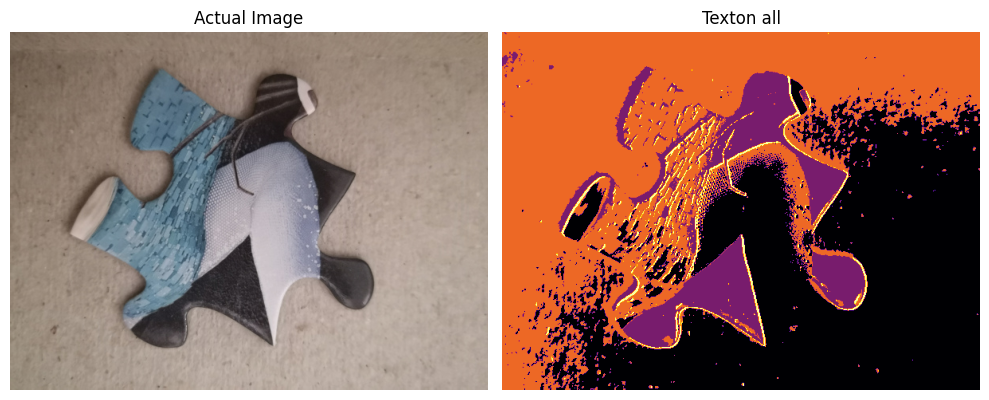

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Actual Image')
plt.imshow(train_image, cmap='inferno')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Texton all')
plt.imshow(texton_train, cmap='inferno')
plt.axis('off')

plt.tight_layout()
plt.show()

Clustering the features works well in segmenting features that are uniform in their intensity, there is a high response to change in intensity and texture.

**CLASSIFIER**

USING THE TRAINING FEATURE VECTOR CALCULATE MEAN AND CO-VARIANCE VALUES

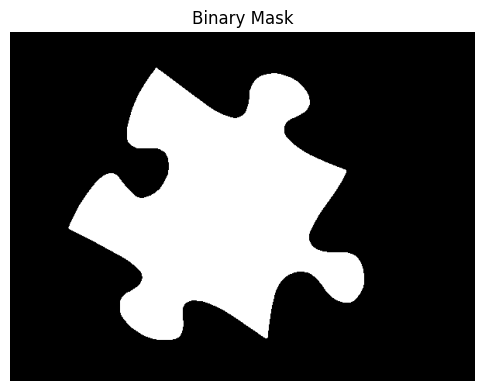

In [ ]:
# convert the image to grayscale
train_mask_gray = cv2.cvtColor(train_mask, cv2.COLOR_BGR2GRAY)

_, train_binary_mask = cv2.threshold(train_mask_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # calculates the optimal threshold and applies it to the image

# normalising the binary mask to values 0 and 1
train_mask_binary = train_binary_mask // 255

plt.figure(figsize=(6, 6))
plt.imshow(train_mask_binary, cmap='gray')
plt.title("Binary Mask")
plt.axis('off')
plt.show()

In [ ]:
# Extract foreground and background features
fg_features = full_feature_train[train_mask_binary > 0]
bg_features = full_feature_train[train_mask_binary == 0]

# Calculate mean and covariance for foreground pixels
mean_fg = np.mean(fg_features, axis=0)
cov_fg = np.cov(fg_features, rowvar=False)

# Calculate mean and covariance for background pixels
mean_bg = np.mean(bg_features, axis=0)
cov_bg = np.cov(bg_features, rowvar=False)

N_fg  = np.sum(train_binary_mask > 0)
N_bg =  np.sum(train_binary_mask == 0)

N = np.sum(train_binary_mask)

In [ ]:
def classifier(full_feature_vector, threshold):
    # Probability densities for foreground and background
    pr_x_fg = stats.multivariate_normal.pdf(full_feature_vector, mean=mean_fg, cov=cov_fg, allow_singular=True)
    pr_x_bg = stats.multivariate_normal.pdf(full_feature_vector, mean=mean_bg, cov=cov_bg, allow_singular=True)

    # Compute the denominator while ensuring numerical stability
    denominator = (pr_x_fg * N_fg) + (pr_x_bg * N_bg)

    # Avoid division by zero and handle numerical issues
    with np.errstate(divide='ignore', invalid='ignore'):
        pr_fg_x = np.divide(pr_x_fg * N_fg, denominator, out=np.zeros_like(pr_x_fg), where=denominator != 0)

    # Classify the image based on the threshold
    classified_image = np.where(pr_fg_x < threshold, 0, 255).astype(np.uint8)

    return classified_image

CLASSIFY THE VALIDATION IMAGE USING A THRESHOLD OF 0.95

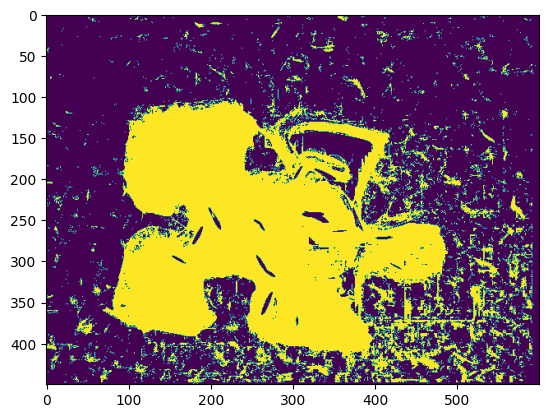

In [ ]:
classified_image_test=classifier(full_feature_test, 0.95)
plt.imshow(classified_image_test)

 FUNCTION TO CALCUALTE EVALUATION METRICS

In [ ]:
def calculate_metrics(predicted_mask, mask):
    # Ensure the masks are in uint8 format for thresholding
    predicted_mask = predicted_mask.astype(np.uint8)
    mask = mask.astype(np.uint8)

    # Apply thresholding to obtain binary masks
    _, predicted_mask = cv2.threshold(predicted_mask, 127, 255, cv2.THRESH_BINARY)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Flatten the masks
    predicted_mask_flat = predicted_mask.flatten()
    ground_truth_mask_flat = mask.flatten()

    # Calculate metrics
    accuracy = accuracy_score(ground_truth_mask_flat, predicted_mask_flat)
    precision = precision_score(ground_truth_mask_flat, predicted_mask_flat, pos_label=255)
    recall = recall_score(ground_truth_mask_flat, predicted_mask_flat, pos_label=255)
    f1 = f1_score(ground_truth_mask_flat, predicted_mask_flat, pos_label=255)
    conf_matrix = confusion_matrix(ground_truth_mask_flat, predicted_mask_flat, labels=[0, 255])

    return accuracy, precision, recall, f1, conf_matrix

CALCULATE EVALUATION METRICS FOR TEST SET

In [ ]:
test_mask_gray = cv2.cvtColor(test_mask, cv2.COLOR_BGR2GRAY)

Accuracy: 0.8203962962962963
Precision: 0.562636049772702
Recall: 0.9130056189005356
F1 Score: 0.6962257650264665


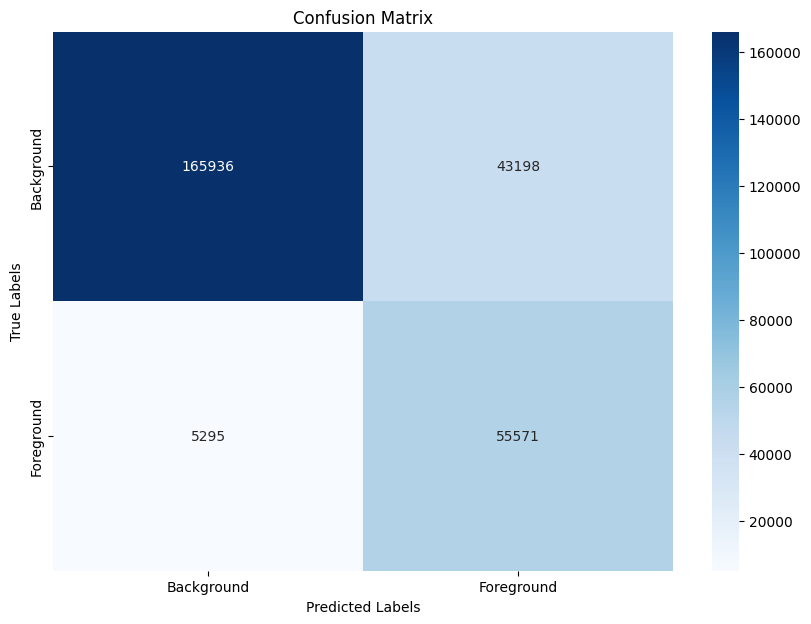

In [ ]:
accuracy, precision, recall, f1, conf_matrix = calculate_metrics(classified_image_test, test_mask_gray)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
        xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

DEFINE FUNCTION TO SHOW HOW METRICS CHANGE AS THE THRESHOLD VALUES CHANGE

In [ ]:
def plot_metrics_and_confusion_components(feature_vector,mask):
    # Define thresholds and empty lists to store metrics
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]  # Example thresholds
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Initialize lists to store confusion matrix components
    TPs = []
    FPs = []
    TNs = []
    FNs = []

    for threshold in thresholds:
        # Call the classifier function with feature_vector_val and the current threshold
        imge = classifier(feature_vector, threshold)
        # Calculate metrics using the generated image and the validation mask
        accuracy, precision, recall, f1, conf_matrix = calculate_metrics(imge, mask)

        # Store the metrics in lists
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Store confusion matrix components
        TPs.append(conf_matrix[0, 0])
        FPs.append(conf_matrix[0, 1])
        TNs.append(conf_matrix[1, 1])
        FNs.append(conf_matrix[1, 0])

    plt.figure(figsize=(18, 12))

    plt.subplot(3, 2, 1)
    plt.plot(thresholds, accuracies, marker='o', color='b')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')
    plt.grid(True)

    plt.subplot(3, 2, 2)
    plt.plot(thresholds, precisions, marker='o', color='g')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('Precision vs. Threshold')
    plt.grid(True)

    plt.subplot(3, 2, 3)
    plt.plot(thresholds, recalls, marker='o', color='r')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.title('Recall vs. Threshold')
    plt.grid(True)

    plt.subplot(3, 2, 4)
    plt.plot(thresholds, f1_scores, marker='o', color='m')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold')
    plt.grid(True)

    # Confusion Matrix Components Plot: True Positives
    plt.subplot(3, 2, 5)
    plt.plot(thresholds, TPs, marker='o', color='c', label='TP')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.title('True Positives vs. Threshold')
    plt.grid(True)

    # Confusion Matrix Components Plot: False Positives
    plt.subplot(3, 2, 6)
    plt.plot(thresholds, FPs, marker='o', color='m', label='FP')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.title('False Positives vs. Threshold')
    plt.grid(True)

    # Confusion Matrix Components Plot: True Negatives
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 2, 1)
    plt.plot(thresholds, TNs, marker='o', color='y', label='TN')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.title('True Negatives vs. Threshold')
    plt.grid(True)

    # Confusion Matrix Components Plot: False Negatives
    plt.subplot(2, 2, 2)
    plt.plot(thresholds, FNs, marker='o', color='k', label='FN')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.title('False Negatives vs. Threshold')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

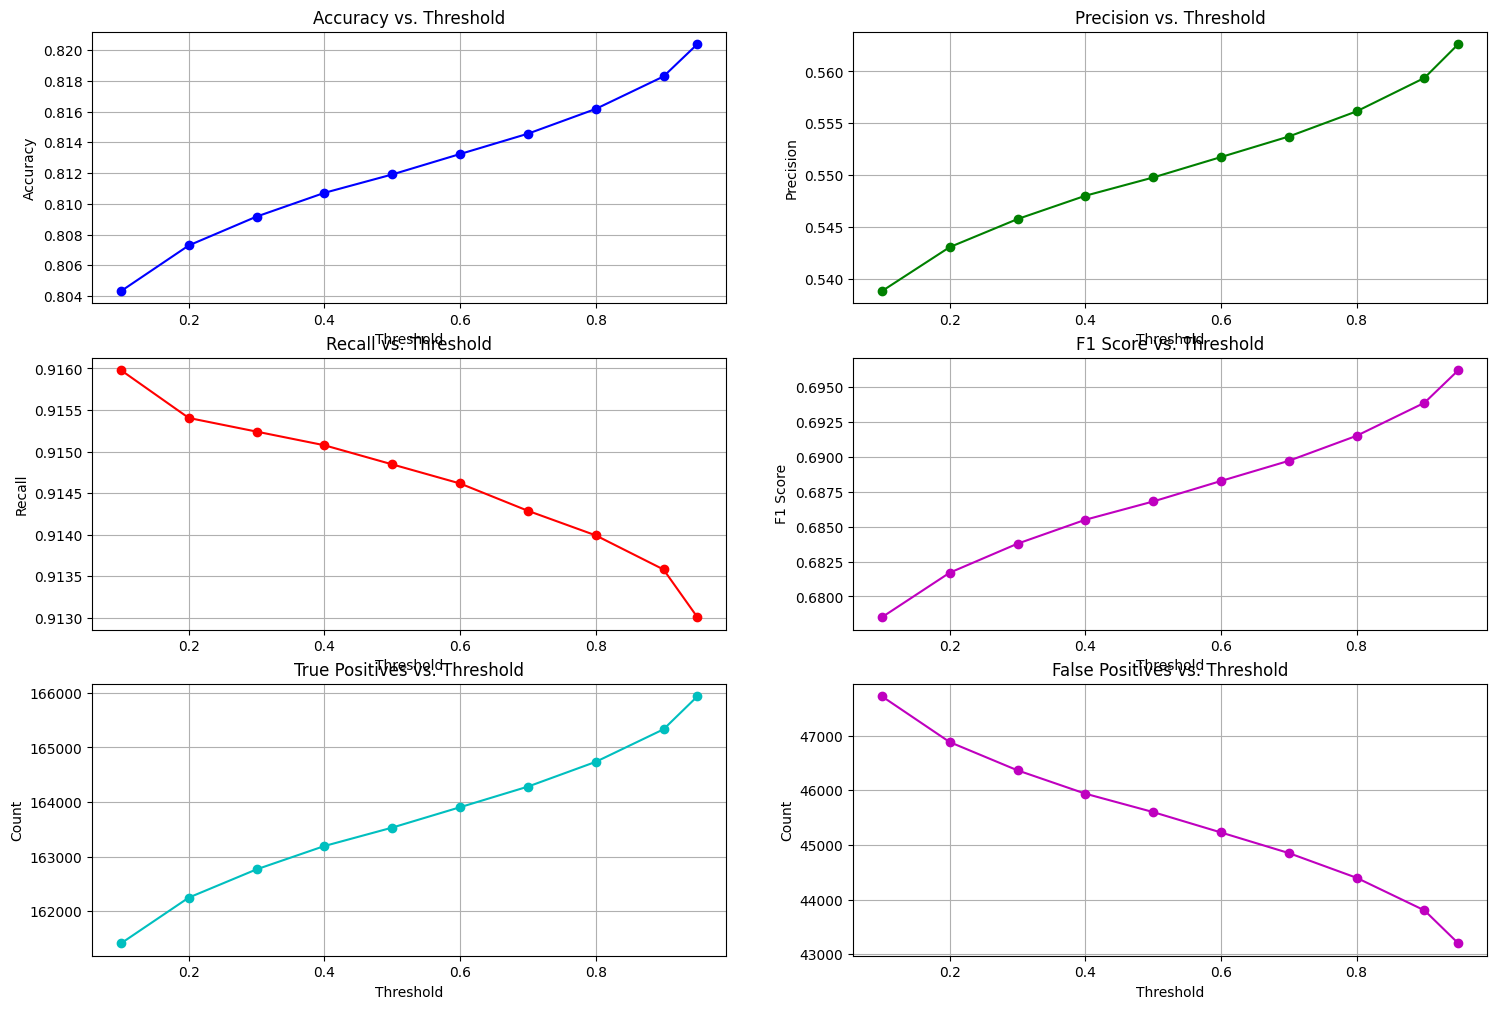

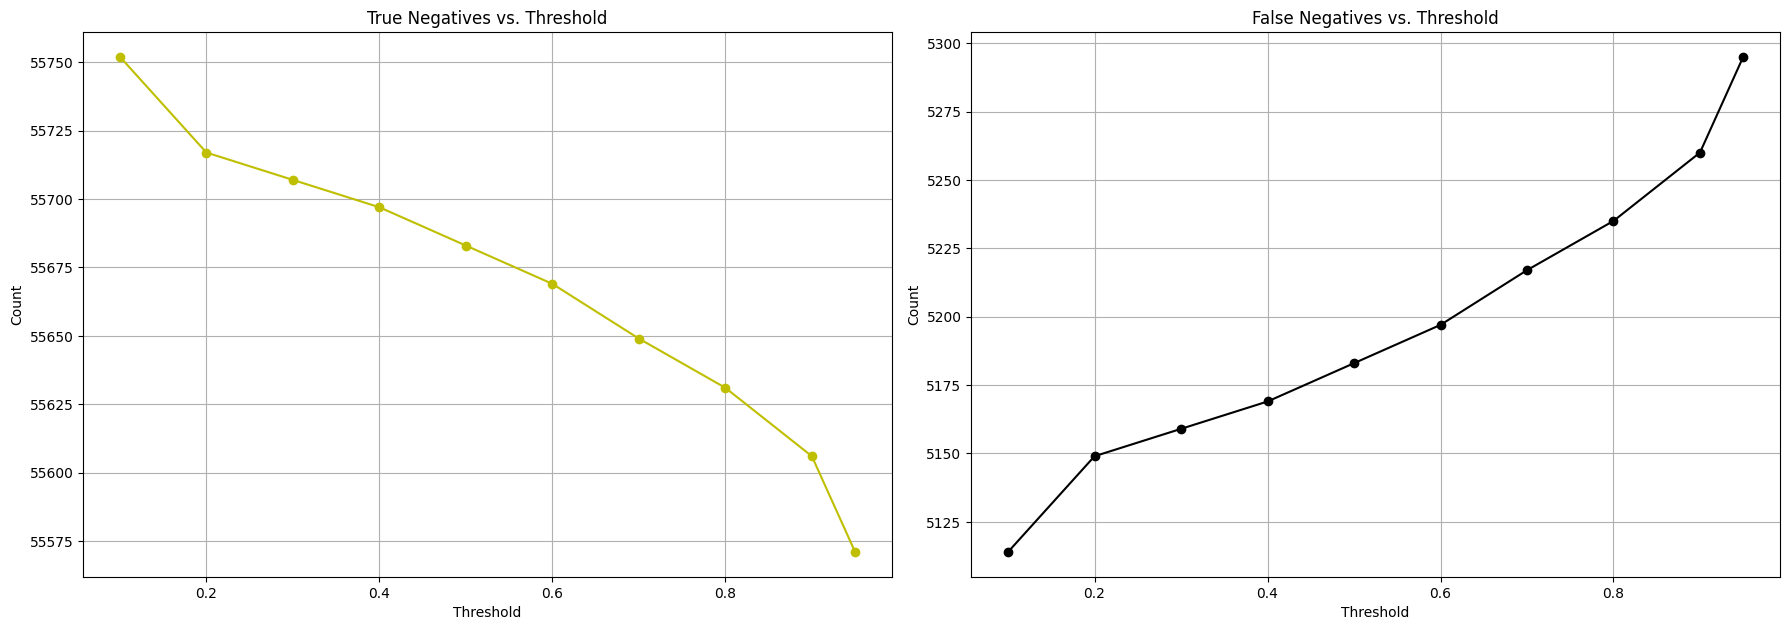

In [ ]:
plot_metrics_and_confusion_components(full_feature_test,test_mask_gray)

 Increaing threshold values have a positive effect on evaluation metrics accuracy , precision  and the F1 score increase as the threshold increases. Though the  margin of difference is very small, showing high distinction between attributes of puzzle pieces and background.

FUNCTION TO PLOT ROC CURVE

In [ ]:
def plot_roc_curve(predicted_probs, ground_truth_mask):

    # Ensure predicted_probs is a flat array
    predicted_probs = predicted_probs.flatten()

    # Flatten the ground truth mask
    ground_truth_mask_flat = ground_truth_mask.flatten()

    # Convert ground truth to binary format if it's not already
    ground_truth_binary = np.where(ground_truth_mask_flat > 0, 1, 0)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(ground_truth_binary, predicted_probs)
    roc_auc = roc_auc_score(ground_truth_binary, predicted_probs)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

    return roc_auc

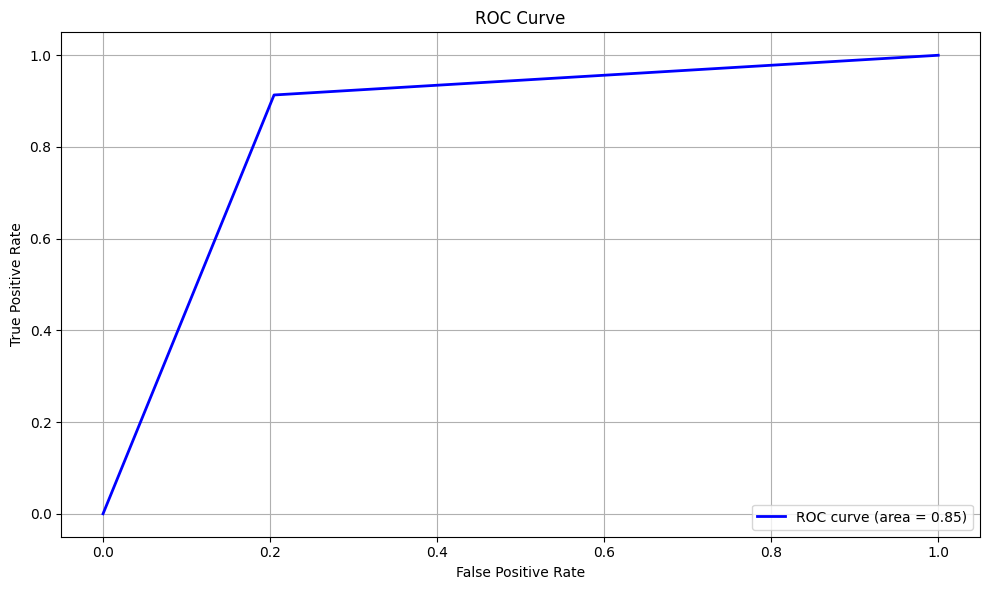

0.854305652874916

In [ ]:
plot_roc_curve(classified_image_test, test_mask_gray)

FUNCTION TO EVALUATE IOU

In [ ]:
def evaluate_iou_vs_thresholds( feature_vector,mask):
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

    ious = []  # List to store IoU scores

    for threshold in thresholds:
        # Get predicted mask
        predicted_mask = classifier(feature_vector, threshold)

        # Ensure predicted mask and ground truth mask are binary
        predicted_mask_binary = (predicted_mask > 0).astype(np.int32)
        ground_truth_mask_binary = (mask > 0).astype(np.int32)

        # Calculate Intersection and Union for IoU
        intersection = np.logical_and(predicted_mask_binary, ground_truth_mask_binary).sum()
        union = np.logical_or(predicted_mask_binary, ground_truth_mask_binary).sum()
        iou_score = intersection / union if union != 0 else 0

        # Print IoU score for the current threshold
        print(f'Threshold: {threshold}, IoU Score: {iou_score:.4f}')

        # Store IoU score
        ious.append(iou_score)

    # IoU score plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, ious, marker='o', color='c')
    plt.xlabel('Threshold')
    plt.ylabel('IoU Score')
    plt.title('IoU Score vs. Threshold')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Threshold: 0.1, IoU Score: 0.5177
Threshold: 0.2, IoU Score: 0.5214
Threshold: 0.3, IoU Score: 0.5239
Threshold: 0.4, IoU Score: 0.5259
Threshold: 0.5, IoU Score: 0.5274
Threshold: 0.6, IoU Score: 0.5291
Threshold: 0.7, IoU Score: 0.5308
Threshold: 0.8, IoU Score: 0.5329
Threshold: 0.9, IoU Score: 0.5357
Threshold: 0.95, IoU Score: 0.5385


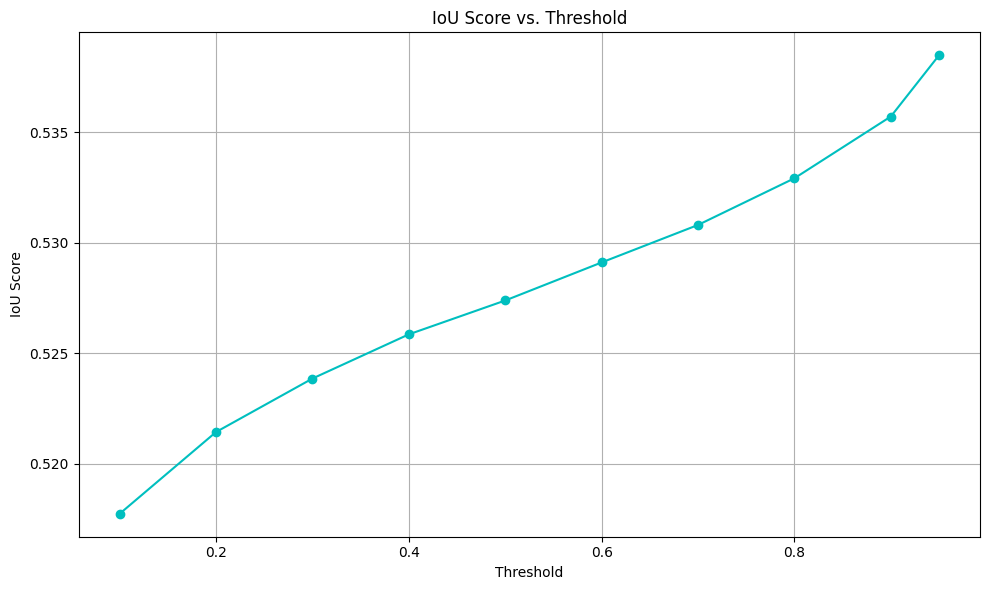

In [ ]:
evaluate_iou_vs_thresholds(full_feature_test,test_mask_gray)

MR8 and RE-EVALUATION

APPLY MR8 FEATURES ON HSV

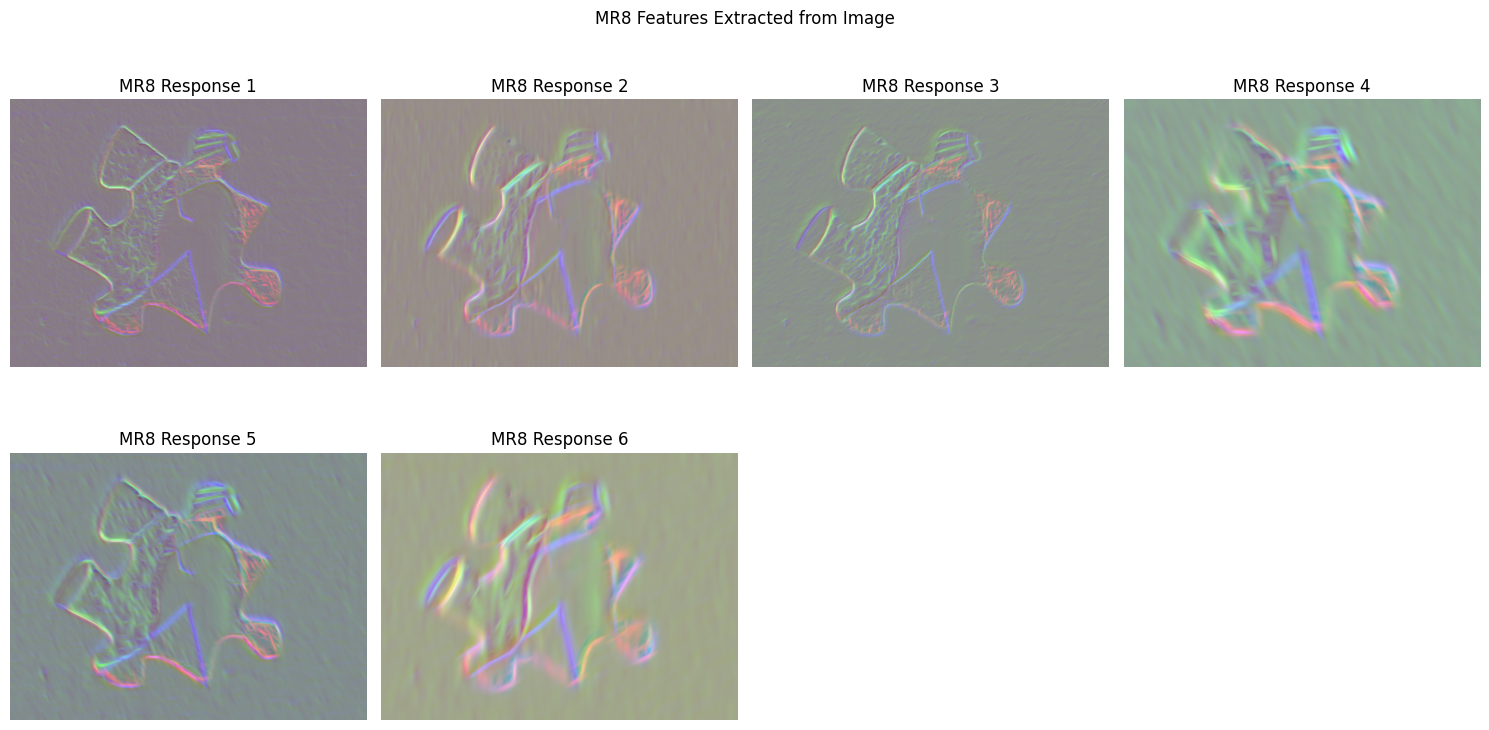

In [ ]:
# Generate the RFS filter bank
rfs_bank, sigma_pairs, thetas = generate_rfs_bank()

# Apply the RFS bank to the image and extract MR8 features
mr8_features_hsv_train = apply_rfs_bank_to_image(train_image_hsv, rfs_bank, sigma_pairs, thetas)
mr8_features_hsv_val = apply_rfs_bank_to_image(val_image_hsv, rfs_bank, sigma_pairs, thetas)
mr8_features_hsv_test= apply_rfs_bank_to_image(test_image_hsv, rfs_bank, sigma_pairs, thetas)

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i, ax in enumerate(axes.flat):
    if i < len(mr8_features_hsv_train):
        ax.imshow(mr8_features_hsv_train[i] , cmap = 'inferno')
        ax.set_title(f"MR8 Response {i + 1}")
        ax.axis('off')
    else:
        ax.remove()

plt.suptitle('MR8 Features Extracted from Image')
plt.tight_layout()
plt.show()

In [ ]:
# Reshape MR8 HSV array
mr8_features_hsv_train  = np.array(mr8_features_hsv_train)
mr8_features_hsv_train= np.moveaxis(mr8_features_hsv_train, 0, -1)
mr8_features_hsv_train  = mr8_features_hsv_train.reshape(450, 600, -1)

mr8_features_hsv_val  = np.array(mr8_features_hsv_val)
mr8_features_hsv_val= np.moveaxis(mr8_features_hsv_val, 0, -1)
mr8_features_hsv_val  = mr8_features_hsv_val.reshape(450, 600, -1)

mr8_features_hsv_test  = np.array(mr8_features_hsv_test)
mr8_features_hsv_test= np.moveaxis(mr8_features_hsv_test, 0, -1)
mr8_features_hsv_test  = mr8_features_hsv_test.reshape(450, 600, -1)

ADD MR8 HSV FEATURES TO THE OTHER FEATURES

In [ ]:
full_feature_train2 = np.concatenate((feature_vector_train, mr8_features_hsv_train), axis=2)
full_feature_val2 = np.concatenate((feature_vector_val, mr8_features_hsv_val), axis=2)
full_feature_test2 = np.concatenate((feature_vector_test, mr8_features_hsv_test), axis=2)

**RE-CLASSIFY TRAIN IMAGE USING NEW FEATURES**

RE-CALCULATE MEAN AND COVARIANCE FOR CLASSIFICATION

In [ ]:
#Extract foreground and background features
fg_features = full_feature_train2[train_mask_binary > 0]
bg_features = full_feature_train2[train_mask_binary == 0]

# Calculate mean and covariance for foreground pixels
mean_fg = np.mean(fg_features, axis=0)
cov_fg = np.cov(fg_features, rowvar=False)

# Calculate mean and covariance for background pixels
mean_bg = np.mean(bg_features, axis=0)
cov_bg = np.cov(bg_features, rowvar=False)

N_fg  = np.sum(train_mask > 0)
N_bg =  np.sum(train_mask == 0)
N = np.sum(train_mask)

RECLASSIFY TEST IMAGE

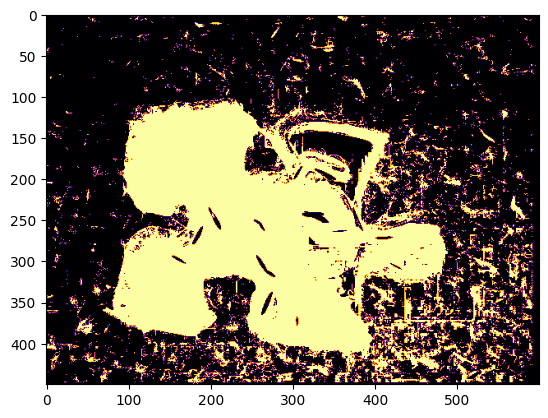

In [ ]:
classified_image_train=classifier(full_feature_test2,0.35)
classified_image = normalize(classified_image_test)
plt.imshow(classified_image_test, cmap = 'inferno')

EVALUATE THE CLASSIFIER

Accuracy: 0.8203962962962963
Precision: 0.562636049772702
Recall: 0.9130056189005356
F1 Score: 0.6962257650264665


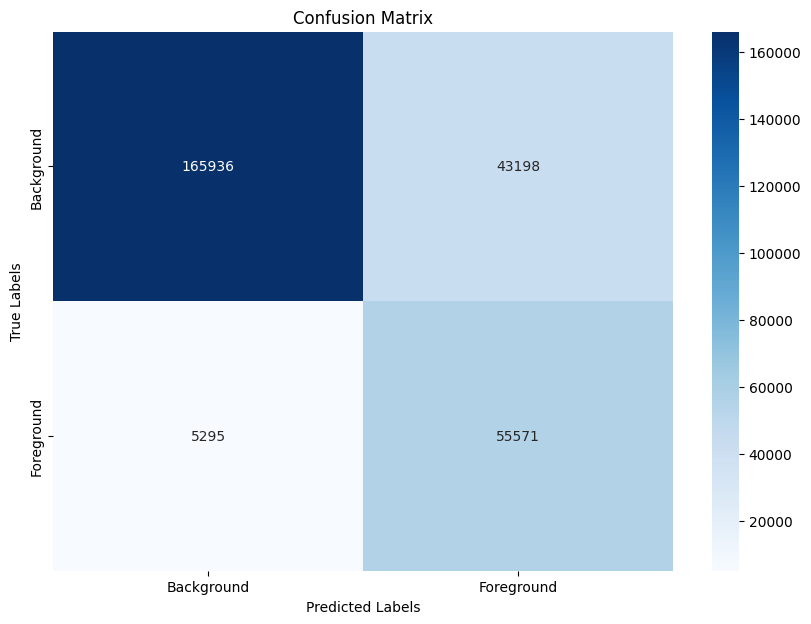

In [ ]:
accuracy, precision, recall, f1, conf_matrix = calculate_metrics(classified_image_test, test_mask_gray)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
        xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

QUESTION 4. 5 -- LOGISTIC REGRESSION

In [ ]:
val_mask_gray = cv2.cvtColor(val_mask, cv2.COLOR_BGR2GRAY)

In [ ]:
X_train = full_feature_train2.reshape(-1, full_feature_train2.shape[-1])
X_val = full_feature_val2.reshape(-1, full_feature_val2.shape[-1])
y_train = train_mask_binary.flatten()
y_val = val_mask_binary.flatten()

X_test = full_feature_test2.reshape(-1, full_feature_test2.shape[-1])
y_test = test_mask_binary.flatten()

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def calculate_metrics(predicted_mask, true_mask):
    if len(true_mask.shape) == 3:
        true_mask = true_mask[:,:,0]

    accuracy = np.mean(predicted_mask == true_mask)
    precision = np.sum((predicted_mask == 1) & (true_mask == 1)) / np.sum(predicted_mask == 1)
    recall = np.sum((predicted_mask == 1) & (true_mask == 1)) / np.sum(true_mask == 1)
    f1 = 2 * (precision * recall) / (precision + recall)
    conf_matrix = confusion_matrix(true_mask.flatten(), predicted_mask.flatten())
    return accuracy, precision, recall, f1, conf_matrix

In [ ]:
# Train logistic regression model
logistic_regression = LogisticRegression(max_iter=2000, class_weight='balanced')
logistic_regression.fit(X_train_scaled, y_train)

y_val_pred = logistic_regression.predict(X_val_scaled)
y_test_pred = logistic_regression.predict(X_test_scaled)

y_val_pred_img = y_val_pred.reshape(val_mask_gray.shape)
y_test_pred_img = y_test_pred.reshape(test_mask_gray.shape)

Accuracy: 0.960362962962963
Precision: 0.9415845070422535
Recall: 0.878684322938915
F1 Score: 0.9090476433294239


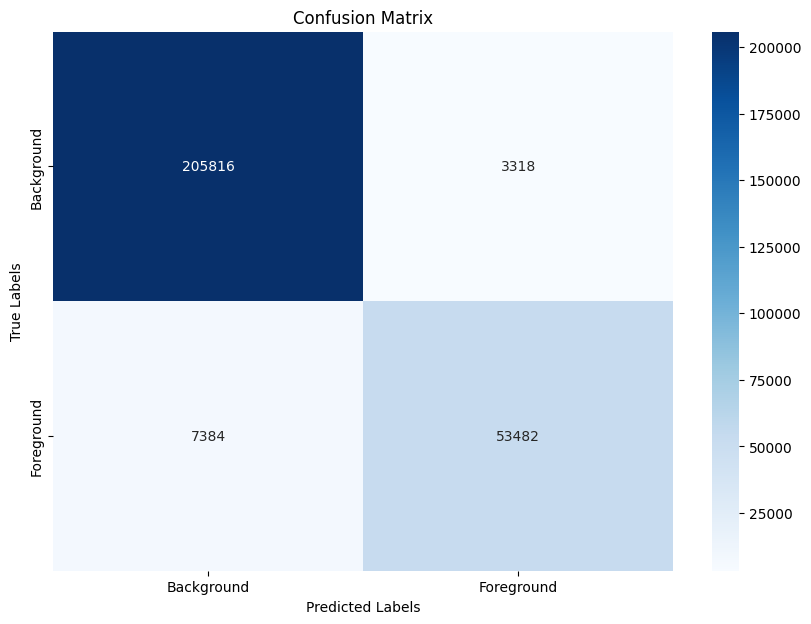

In [ ]:
test_accuracy, test_precision, test_recall, test_f1, conf_matrix = calculate_metrics(y_test_pred_img, test_mask_binary)

#print("Test Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

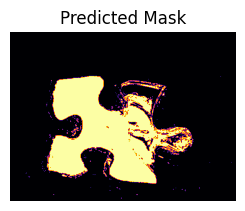

In [ ]:
plt.subplot(1, 2, 2)
plt.imshow(y_test_pred_img, cmap='inferno')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

PCA

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train.shape[1]}, Reduced number of features: {X_train_pca.shape[1]}")

Original number of features: 183, Reduced number of features: 97


In [ ]:
logistic_regression_pca = LogisticRegression(max_iter=2000, class_weight='balanced')
logistic_regression_pca.fit(X_train_pca, y_train)

y_val_pca_pred = logistic_regression_pca.predict(X_val_pca)
y_test_pca_pred = logistic_regression_pca.predict(X_test_pca)

y_val_pca_pred_img = y_val_pca_pred.reshape(val_mask_gray.shape)
y_test_pca_pred_img = y_test_pca_pred.reshape(test_mask_gray.shape)

Accuracy: 0.9297777777777778
Precision: 0.9378160391157173
Recall: 0.7373903328623533
F1 Score: 0.8256134800044148


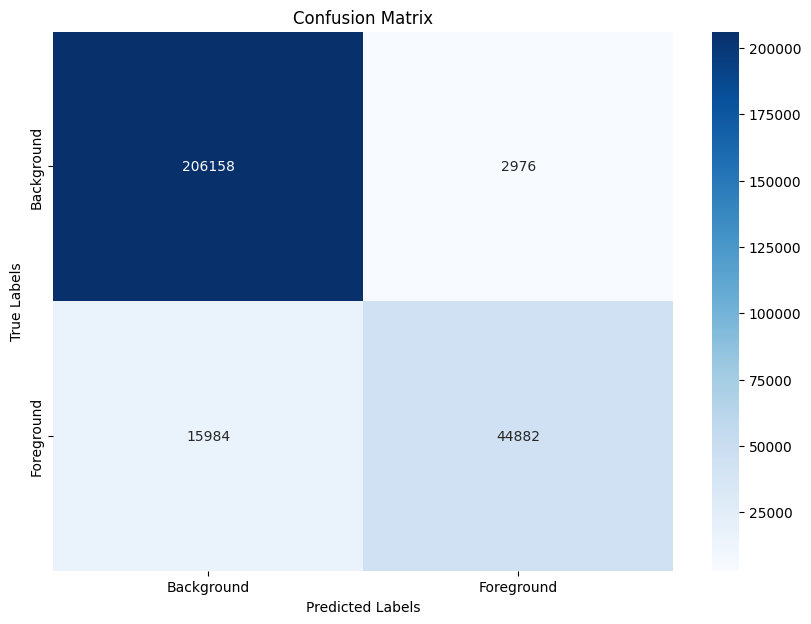

In [ ]:
test_pca_accuracy, test_pca_precision, test_pca_recall, test_pca_f1, conf_matrix = calculate_metrics(y_test_pca_pred_img, test_mask_binary)

print("Accuracy:", test_pca_accuracy)
print("Precision:", test_pca_precision)
print("Recall:", test_pca_recall)
print("F1 Score:", test_pca_f1)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

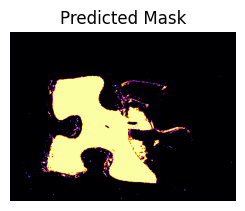

In [ ]:
plt.subplot(1, 2, 2)
plt.imshow(y_test_pca_pred_img, cmap='inferno')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

Best number of features: all
Accuracy: 0.960362962962963
Precision: 0.9415845070422535
Recall: 0.878684322938915
F1 Score: 0.9090476433294239


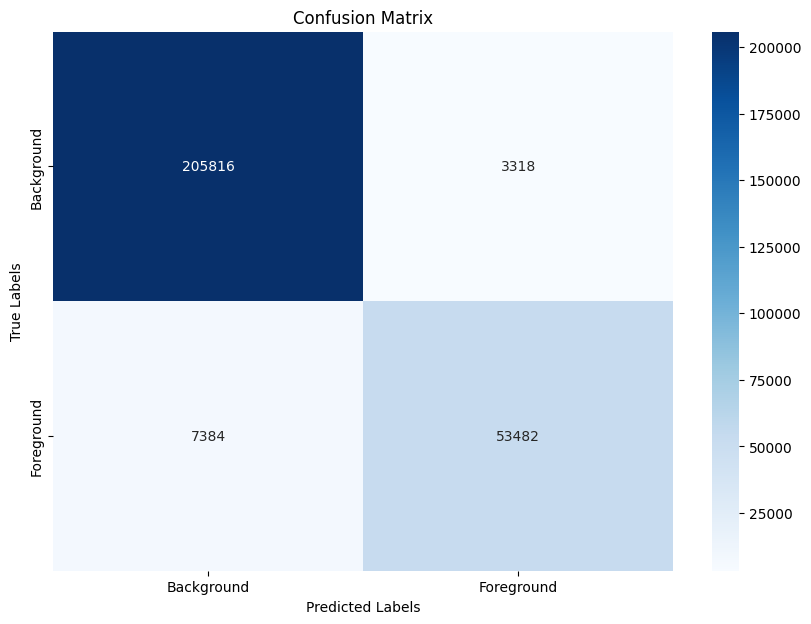

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_classif)),
    ('logreg', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

# Define the parameter grid
param_grid = {
    'select__k': [5, 10, 15, 20, 'all']  # Tuning the number of features
}

# GridSearchCV object to find the best number of features
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Fit the GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Print the best number of features found
print("Best number of features:", grid_search.best_params_['select__k'])

# Get the best pipeline with the best number of features
best_pipeline = grid_search.best_estimator_

# Transform the training, validation, and test data using the best selector
X_train_selected = best_pipeline.named_steps['select'].transform(X_train_scaled)
X_val_selected = best_pipeline.named_steps['select'].transform(X_val_scaled)
X_test_selected = best_pipeline.named_steps['select'].transform(X_test_scaled)

# Predict on validation and test sets using the new model
y_val_selected_pred = best_pipeline.predict(X_val_selected)
y_test_selected_pred = best_pipeline.predict(X_test_selected)

# Reshape the predicted masks to the original image shape
y_val_selected_pred_img = y_val_selected_pred.reshape(val_mask_gray.shape)
y_test_selected_pred_img = y_test_selected_pred.reshape(test_mask_gray.shape)


# Evaluate the model with selected features on the test set
test_selected_accuracy, test_selected_precision, test_selected_recall, test_selected_f1, conf_matrix = \
    calculate_metrics(y_test_selected_pred_img, test_mask_binary)

print("Accuracy:", test_selected_accuracy)
print("Precision:", test_selected_precision)
print("Recall:", test_selected_recall)
print("F1 Score:", test_selected_f1)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

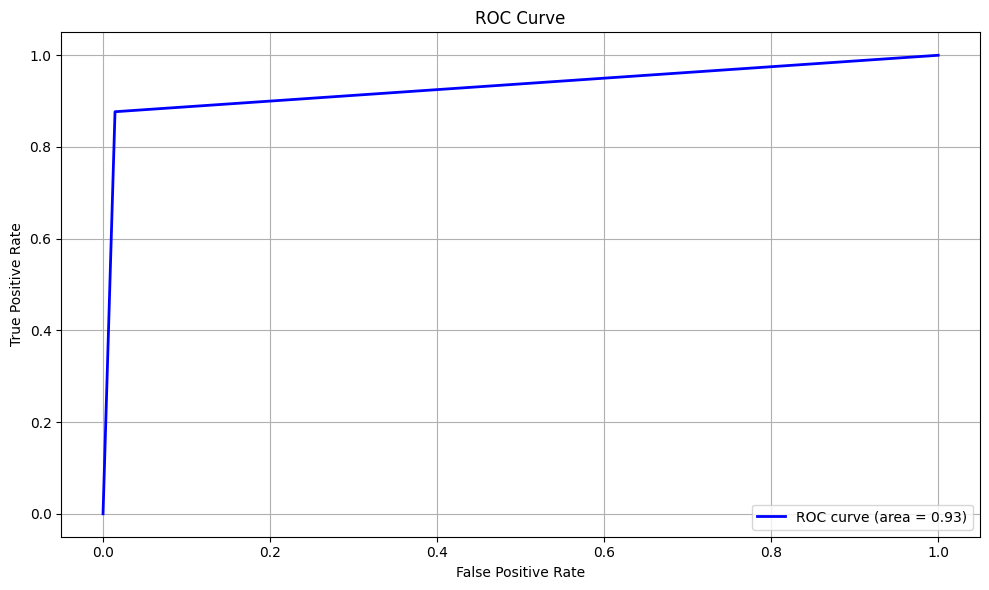

0.931265940020781

In [ ]:
plot_roc_curve(y_test_selected_pred_img, test_mask_gray)

In [ ]:
def calculate_iou(predicted_mask, true_mask, threshold=0.5):

    # Apply the threshold to predicted mask
    predicted_mask_binary = (predicted_mask > threshold).astype(np.int32)
    true_mask_binary = (true_mask > 0).astype(np.int32)

    # Calculate Intersection and Union for IoU
    intersection = np.logical_and(predicted_mask_binary, true_mask_binary).sum()
    union = np.logical_or(predicted_mask_binary, true_mask_binary).sum()
    iou_score = intersection / union if union != 0 else 0

    return iou_score

In [ ]:
iou_score = calculate_iou(y_test_selected_pred_img, test_mask_gray, threshold=0.5)
print(f"IoU Score: {iou_score:.4f}")

IoU Score: 0.8361


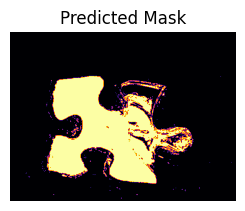

In [ ]:
plt.subplot(1, 2, 2)
plt.imshow(y_test_selected_pred_img, cmap='inferno')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

**Conclusion**
From our experiments, including logistic regression with all features, PCA transformation, and feature selection with grid search, it is evident that the model using all features consistently delivers the best performance metrics. PCA did not show significant improvements and led to decreased performance on the test set. Therefore, based on these results, the model utilizing all features remains the most effective.